# Hand pose

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader
import sys

In [2]:
from funcs import COLORMAP, heatmaps_to_coordinates, display_predictions
from variables import NUM_OF_KEYPOINTS, NUM_OF_CHANNELS, ORG_IMG_SIZE, CVT_IMG_SIZE, DATASET_MEAN, DATASET_STD
from models import ShallowUNet
from datasets import FreiHand

# Inference

In [3]:
# Inference parameters.
DATASETS_PATH = "/Users/borjagq/Desktop/HandData/"
TEST_BATCH_SIZE = 4
DEVICE = "cpu"

LABEL = "# of dataset size"
NAME = "size"

In [4]:
val_list = []
med_error_all = []
mse_error_all = []
pck_error_all = []

for val in [31000, 50000, 75000, 100000]:

    # CHANGE HERE
    num_of_joint_angles = 31000
    num_of_arm_positions = 31000
    num_of_arm_rotations = 31000
    num_of_skin_tones = 31000
    num_of_lighting = 31000
    num_of_shininess = 31000
    num_of_backgrounds = 15000
    num_of_camera_params = 1
    dataset_size = val

    dataset = str(num_of_joint_angles) + "_" + str(num_of_arm_positions) + "_" + str(num_of_arm_rotations) + "_" + str(num_of_skin_tones) + "_" + str(num_of_lighting) + "_" + str(num_of_shininess) + "_" + str(num_of_backgrounds) + "_" + str(num_of_camera_params) + "_" + str(dataset_size)

    model_path = "/Users/borjagq/Desktop/Trinity/Dissertation/Results/" + dataset + "/model_final"

    model = ShallowUNet(NUM_OF_CHANNELS, NUM_OF_KEYPOINTS)
    model.load_state_dict(
        torch.load(model_path, map_location=torch.device(DEVICE))
    )
    model.eval()

    config = {
        "data_dir": DATASETS_PATH + dataset,
        "test_batch_size": TEST_BATCH_SIZE,
        "device": DEVICE,
    }

    # Test dataset.
    test_dataset = FreiHand(config=config, dataset_type="test")
    test_dataloader = DataLoader(
        test_dataset, TEST_BATCH_SIZE, shuffle=True, drop_last=False, num_workers=2,
    )

    # Init an accuracy DS and go through the data.
    mean_euclidean_distance = []
    mean_squared_error = []
    mean_correct_keypoints = []

    for data in tqdm(test_dataloader):

        # Loads the input into the model.
        inputs = data["image"]
        pred_heatmaps = model(inputs)

        # Get the prediction heatmaps and the keypoints.
        pred_heatmaps = pred_heatmaps.detach().numpy()
        true_keypoints = data["keypoints"].numpy()
        pred_keypoints = heatmaps_to_coordinates(pred_heatmaps)

        # Get the accuracy for the keypoints.
        # This accuracy is calculated by getting the euclidian distance.
        med_keypoint = ((true_keypoints - pred_keypoints) ** 2).sum(axis=2) ** (1 / 2)
        mse_keypoint = ((true_keypoints - pred_keypoints) ** 2).sum(axis=2)

        mean_euclidean_distance.extend(list(med_keypoint.mean(axis=1)))
        mean_squared_error.extend(list(mse_keypoint.mean(axis=1)))
        mean_correct_keypoints = np.sum(med_keypoint <= 0.05, axis=1)

    med_error = np.mean(mean_euclidean_distance) * 100
    mse_error = np.mean(mean_squared_error) * 100
    mck_error = np.mean(mean_correct_keypoints)
    pck_error = (mck_error / 21) * 100

    val_list.append(val)
    med_error_all.append(med_error)
    mse_error_all.append(mse_error)
    pck_error_all.append(pck_error)

    print(dataset)
    print("{}\t{}\t{}\t{}".format(med_error, mse_error, mck_error, pck_error))

    file_synth = open("/Users/borjagq/Downloads/synth_data.csv", "a")
    file_synth.write("{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\n".format(dataset, num_of_joint_angles, num_of_arm_positions, num_of_arm_rotations, num_of_skin_tones, num_of_lighting, num_of_shininess, num_of_backgrounds, num_of_camera_params, dataset_size, med_error, mse_error, mck_error, pck_error))
    file_synth.close()

100%|██████████| 390/390 [00:36<00:00, 10.79it/s]


31000_31000_31000_31000_31000_31000_15000_1_31000
8.04374455390144	2.955407824145647	6.25	29.761904761904763


100%|██████████| 390/390 [00:35<00:00, 11.11it/s]


31000_31000_31000_31000_31000_31000_15000_1_50000
7.295871569993652	2.3979129072212246	15.0	71.42857142857143


100%|██████████| 390/390 [00:34<00:00, 11.39it/s]


31000_31000_31000_31000_31000_31000_15000_1_75000
7.122370926760156	2.5106300552046545	14.0	66.66666666666666


100%|██████████| 390/390 [00:35<00:00, 11.07it/s]

31000_31000_31000_31000_31000_31000_15000_1_100000
6.311653699056147	2.0631771144795064	17.0	80.95238095238095


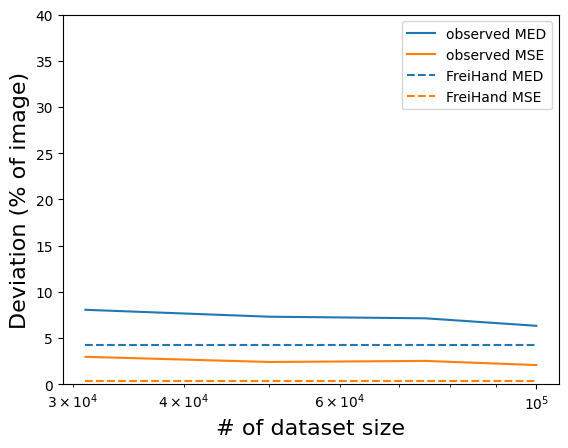

In [5]:
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = '10'

plt.plot(val_list, med_error_all, label="observed MED", c="tab:blue")
plt.plot(val_list, mse_error_all, label="observed MSE", c="tab:orange")
plt.plot(val_list, [4.2736] * len(val_list), '--', label="FreiHand MED", c="tab:blue")
plt.plot(val_list, [0.3232] * len(val_list), '--', label="FreiHand MSE", c="tab:orange")

plt.xlabel(LABEL, fontsize=16)
plt.ylabel("Deviation (% of image)", fontsize=16)

plt.ylim(0, 40)
plt.xscale("log")

plt.legend()

plt.savefig("/Users/borjagq/Desktop/Results/" + NAME + "_synth_deviation.png")

plt.show()

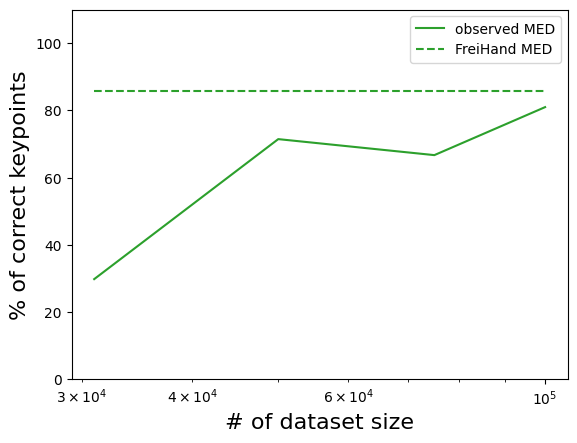

In [6]:
plt.plot(val_list, pck_error_all, label="observed MED", c="tab:green")
plt.plot(val_list, [85.7143] * len(val_list), '--', label="FreiHand MED", c="tab:green")

plt.xlabel(LABEL, fontsize=16)
plt.ylabel("% of correct keypoints", fontsize=16)

plt.ylim(0, 110)
plt.xscale("log")

plt.legend()

plt.savefig("/Users/borjagq/Desktop/Results/" + NAME + "_synth_pck.png")

plt.show()

In [7]:
val_list = []
med_error_all = []
mse_error_all = []
pck_error_all = []

for val in [31000, 50000, 75000, 100000]:

    # CHANGE HERE
    num_of_joint_angles = 31000
    num_of_arm_positions = 31000
    num_of_arm_rotations = 31000
    num_of_skin_tones = 31000
    num_of_lighting = 31000
    num_of_shininess = 31000
    num_of_backgrounds = 15000
    num_of_camera_params = 1
    dataset_size = val

    dataset = str(num_of_joint_angles) + "_" + str(num_of_arm_positions) + "_" + str(num_of_arm_rotations) + "_" + str(num_of_skin_tones) + "_" + str(num_of_lighting) + "_" + str(num_of_shininess) + "_" + str(num_of_backgrounds) + "_" + str(num_of_camera_params) + "_" + str(dataset_size)

    model_path = "/Users/borjagq/Desktop/Trinity/Dissertation/Results/" + dataset + "/model_final"

    model = ShallowUNet(NUM_OF_CHANNELS, NUM_OF_KEYPOINTS)
    model.load_state_dict(
        torch.load(model_path, map_location=torch.device(DEVICE))
    )
    model.eval()

    config = {
        "data_dir": DATASETS_PATH + "FreiHand",
        "test_batch_size": TEST_BATCH_SIZE,
        "device": DEVICE,
    }

    # Test dataset.
    test_dataset = FreiHand(config=config, dataset_type="test")
    test_dataloader = DataLoader(
        test_dataset, TEST_BATCH_SIZE, shuffle=True, drop_last=False, num_workers=2,
    )

    # Init an accuracy DS and go through the data.
    mean_euclidean_distance = []
    mean_squared_error = []
    mean_correct_keypoints = []

    for data in tqdm(test_dataloader):

        # Loads the input into the model.
        inputs = data["image"]
        pred_heatmaps = model(inputs)

        # Get the prediction heatmaps and the keypoints.
        pred_heatmaps = pred_heatmaps.detach().numpy()
        true_keypoints = data["keypoints"].numpy()
        pred_keypoints = heatmaps_to_coordinates(pred_heatmaps)

        # Get the accuracy for the keypoints.
        # This accuracy is calculated by getting the euclidian distance.
        med_keypoint = ((true_keypoints - pred_keypoints) ** 2).sum(axis=2) ** (1 / 2)
        mse_keypoint = ((true_keypoints - pred_keypoints) ** 2).sum(axis=2)

        mean_euclidean_distance.extend(list(med_keypoint.mean(axis=1)))
        mean_squared_error.extend(list(mse_keypoint.mean(axis=1)))
        mean_correct_keypoints = np.sum(med_keypoint <= 0.05, axis=1)

    med_error = np.mean(mean_euclidean_distance) * 100
    mse_error = np.mean(mean_squared_error) * 100
    mck_error = np.mean(mean_correct_keypoints)
    pck_error = (mck_error / 21) * 100

    val_list.append(val)
    med_error_all.append(med_error)
    mse_error_all.append(mse_error)
    pck_error_all.append(pck_error)

    print(dataset)
    print("{}\t{}\t{}\t{}".format(med_error, mse_error, mck_error, pck_error))

    file_real = open("/Users/borjagq/Downloads/real_data.csv", "a")
    file_real.write("{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\n".format(dataset, num_of_joint_angles, num_of_arm_positions, num_of_arm_rotations, num_of_skin_tones, num_of_lighting, num_of_shininess, num_of_backgrounds, num_of_camera_params, dataset_size, med_error, mse_error, mck_error, pck_error))
    file_real.close()

100%|██████████| 390/390 [00:35<00:00, 11.02it/s]


31000_31000_31000_31000_31000_31000_15000_1_31000
15.868722844723834	3.4144488606549404	0.75	3.571428571428571


100%|██████████| 390/390 [00:35<00:00, 11.02it/s]


31000_31000_31000_31000_31000_31000_15000_1_50000
16.573898840114186	3.7316272758000384	1.0	4.761904761904762


100%|██████████| 390/390 [00:34<00:00, 11.22it/s]


31000_31000_31000_31000_31000_31000_15000_1_75000
17.835945662427	4.339412622027023	1.0	4.761904761904762


100%|██████████| 390/390 [00:34<00:00, 11.22it/s]

31000_31000_31000_31000_31000_31000_15000_1_100000
17.127826018454435	4.047647295405666	2.0	9.523809523809524


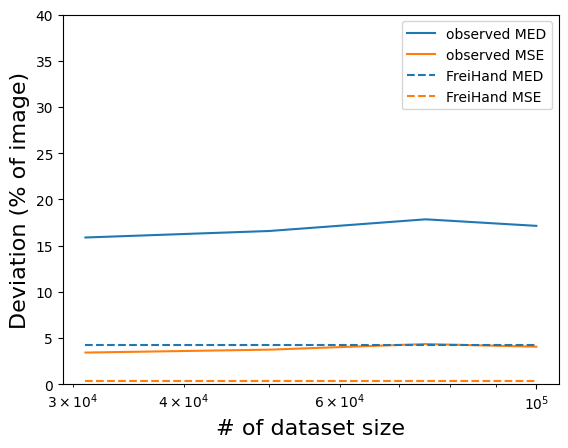

In [8]:
import matplotlib.pyplot as plt
plt.plot(val_list, med_error_all, label="observed MED", c="tab:blue")
plt.plot(val_list, mse_error_all, label="observed MSE", c="tab:orange")
plt.plot(val_list, [4.2736] * len(val_list), '--', label="FreiHand MED", c="tab:blue")
plt.plot(val_list, [0.3232] * len(val_list), '--', label="FreiHand MSE", c="tab:orange")

plt.xlabel(LABEL, fontsize=16)
plt.ylabel("Deviation (% of image)", fontsize=16)

plt.ylim(0, 40)
plt.xscale("log")

plt.legend()

plt.savefig("/Users/borjagq/Desktop/Results/" + NAME + "_real_deviation.png")

plt.show()

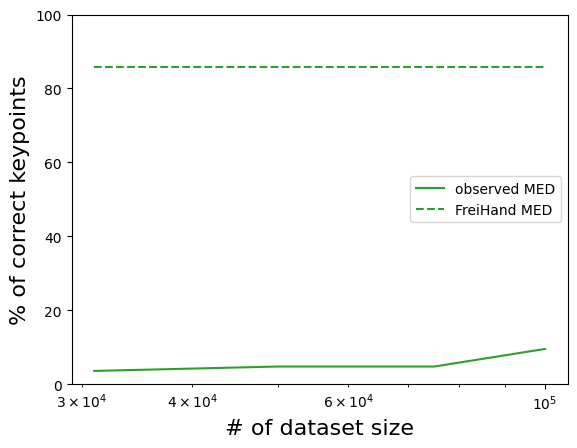

In [9]:
plt.plot(val_list, pck_error_all, label="observed MED", c="tab:green")
plt.plot(val_list, [85.7143] * len(val_list), '--', label="FreiHand MED", c="tab:green")

plt.xlabel(LABEL, fontsize=16)
plt.ylabel("% of correct keypoints", fontsize=16)

plt.ylim(0, 100)
plt.xscale("log")

plt.legend()

plt.savefig("/Users/borjagq/Desktop/Results/" + NAME + "_real_pck.png")

plt.show()

##############

In [10]:
import json

DATASET = "31000_31000_31000_31000_31000_31000_15000_1_31000"
OG_DATASET = "/Users/borjagq/Desktop/HandData 2/" + DATASET + "/"
NEW_DATASET = "/Users/borjagq/Desktop/HandData/" + DATASET + "//"

og_xyz = OG_DATASET + "training_xyz.json"
og_k = OG_DATASET + "training_K.json"

new_xyz = NEW_DATASET + "training_xyz.json"
new_k = NEW_DATASET + "training_K.json"

with open(og_xyz, "r") as f:
    og_xyz_data = json.load(f)

with open(og_k, "r") as f:
    og_k_data = json.load(f)

with open(new_xyz, "r") as f:
    new_xyz_data = json.load(f)

with open(new_k, "r") as f:
    new_k_data = json.load(f)

print("Len OG xyz:", len(og_xyz_data))
print("Len OG k:", len(og_k_data))
print("Len NEW xyz:", len(new_xyz_data))
print("Len NEW k:", len(new_k_data))

Len OG xyz: 31000
Len OG k: 31000
Len NEW xyz: 32560
Len NEW k: 32560


In [11]:
fin_xyz_data = og_xyz_data + new_xyz_data
fin_k_data = og_k_data + new_k_data

print("Len FIN xyz:", len(fin_xyz_data))
print("Len FIN k:", len(fin_k_data))

Len FIN xyz: 63560
Len FIN k: 63560


In [12]:
if False:
    
    with open(new_xyz, "w") as f:
        json.dump(fin_xyz_data, f)

    with open(new_k, "w") as f:
        json.dump(fin_k_data, f)